In [1]:
import numpy as onp
import jax.numpy as jnp
import matplotlib.pyplot as plt

# from scipy.stats import bernoulli
from jax import random, vmap
from jax.example_libraries import optimizers
from jax import grad, value_and_grad
from jax import jit
from jax.scipy.stats import norm, bernoulli
from os.path import join as pjoin
from jax.random import bernoulli as bernoulli_jax, PRNGKey
from jax.scipy.special import logsumexp

from tqdm import tqdm

import matplotlib

font = {"size": 30}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
N_ROUNDS = 10
prior_mean = 0.0
prior_variance = 1.0
# true_thresholds = [-1.5, 1.5]


def expit(x):
    return 1 / (1 + jnp.exp(-x))


def unpack_variational_params(params):
    means, stddevs = params[:4], jnp.exp(params[4:])
    return means, stddevs


def unpack_model_params(params):
    radius, slope, center = params[0], params[1], params[2:]
    return radius, slope, center


def my_norm(x):
    return jnp.sqrt(jnp.sum(x ** 2, axis=1))


def lognormal_logpdf(x, mean, stddev):
    normalizer = -jnp.log(x) - jnp.log(stddev) - 0.5 * jnp.log(2 * jnp.pi)
    lik = -0.5 * (jnp.log(x) - mean) ** 2 / (stddev ** 2)
    return normalizer + lik


class Model:
    def __init__(self, prior_mean, prior_stddev, key=PRNGKey(4)):
        self.key = key
        self.prior_mean = prior_mean
        self.prior_stddev = prior_stddev

    def predict(self, X, radius, slope, center):
        logits = jnp.linalg.norm(X - center, axis=1) - radius
        logits *= slope
        preds = expit(-logits)
        return preds

    def log_density(self, X, Y, params):
        radius, slope, center = unpack_model_params(params)
        transformed_params = self.predict(X, radius, slope, center)

        log_prior_radius = lognormal_logpdf(
            radius, mean=self.prior_mean, stddev=self.prior_stddev
        )
        log_prior_slope = norm.logpdf(
            slope, loc=self.prior_mean, scale=self.prior_stddev
        )
        log_prior_center1 = norm.logpdf(
            center[0], loc=self.prior_mean, scale=self.prior_stddev
        )
        log_prior_center2 = norm.logpdf(
            center[1], loc=self.prior_mean, scale=self.prior_stddev
        )
        log_prior_center = log_prior_center1 + log_prior_center2

        log_likelihood = jnp.sum(bernoulli.logpmf(k=Y, p=transformed_params))
        return log_likelihood + log_prior_radius + log_prior_slope + log_prior_center


class ApproximateModel:
    def __init__(self, key=PRNGKey(4)):
        self.key = key

    def sample(self, params, size):
        means, stddevs = unpack_variational_params(params)
        std_normal_samples = random.normal(key=self.key, shape=(size, 4))
        samples = std_normal_samples * stddevs + means
        return jnp.hstack([jnp.exp(samples[:, 0]).reshape(-1, 1), samples[:, 1:]])
        return samples

    def log_density(self, responses, params):
        means, stddevs = unpack_variational_params(params)

        radius, slope, center = unpack_model_params(responses)

        log_dens_radius = lognormal_logpdf(radius, mean=means[0], stddev=stddevs[0])
        log_dens_slope = norm.logpdf(slope, loc=means[1], scale=stddevs[1])
        log_dens_center = norm.logpdf(center, loc=means[2:], scale=stddevs[2:]).sum()

        return log_dens_radius + log_dens_slope + log_dens_center


def fit_variational_model(
    X,
    Y,
    model_object,
    n_iters=3000,
    print_every=100,
    n_mcmc_samples_vi=5,
    learning_rate=1e-2,
    verbose=False,
):
    # variational_model = ApproximateModel()

    # Initialize variational parameters
    params = jnp.concatenate(
        [
            jnp.ones(4) * 0.5,
            -4 + 1e-4 * random.normal(variational_model.key, shape=(4,)),
        ]
    )

    ## Optimization loop
    opt_init, opt_update, get_params = optimizers.adam(step_size=learning_rate)
    opt_state = opt_init(params)

    VI_objective = lambda params: negative_elbo(
        jnp.array(X),
        jnp.array(Y),
        params,
        model_object,
        variational_model,
        n_mcmc_samples=n_mcmc_samples_vi,
    )

    @jit
    def step(step, opt_state):
        value, grads = value_and_grad(VI_objective)(get_params(opt_state))
        opt_state = opt_update(step, grads, opt_state)
        return value, opt_state

    last_mll = onp.inf
    for step_num in range(int(n_iters)):
        curr_mll, opt_state = step(step_num, opt_state)
        # print(get_params(opt_state))
        # if jnp.isnan(get_params(opt_state)).sum():
        #     import ipdb; ipdb.set_trace()
        if step_num % print_every == 0 and verbose:
            print(
                "Step: {:<15} ELBO: {}".format(
                    step_num, onp.round(-1 * onp.asarray(curr_mll), 2)
                )
            )
            # print(get_params(opt_state))

    fitted_params = get_params(opt_state)
    return fitted_params


def negative_elbo(X, Y, params, model_object, variational_model, n_mcmc_samples=5):
    # Sample from variational posterior

    curr_samples = variational_model.sample(params, size=n_mcmc_samples)

    # Evaluate model and variational log densities
    model_log_density_eval = jnp.array(
        [model_object.log_density(X, Y, s) for s in curr_samples]
    )

    variational_log_density = jnp.array(
        [variational_model.log_density(s, params) for s in curr_samples]
    )

    # Compute approximate ELBO
    curr_elbo = jnp.mean(model_log_density_eval - variational_log_density)

    return -curr_elbo


@jit
def sample_params(variational_params, n_outer_samples=100, n_inner_samples=50):
    # variational_model = ApproximateModel(key=PRNGKey(4))

    # Sample parameters from current model
    #   (either the prior or posterior conditioned on observed data so far)
    param_samples = variational_model.sample(
        params=variational_params, size=n_inner_samples
    )
    param_samples_for_y = variational_model.sample(
        params=variational_params, size=n_outer_samples
    )
    return param_samples, param_samples_for_y


@jit
def predict_one(x, sample):
    return model.predict(
        X=x.reshape(1, -1), radius=sample[0], slope=sample[1], center=sample[2:]
    )


@jit
def eig_calculation(denominator_individual_loglikelihoods, log_numerator):
    denominator_loglikelihoods = jnp.sum(denominator_individual_loglikelihoods, axis=2)

    n_inner_samples = denominator_loglikelihoods.shape[1]
    log_denominator_mean = logsumexp(denominator_loglikelihoods, axis=1) - jnp.log(
        n_inner_samples
    )

    eig = jnp.mean(log_numerator - log_denominator_mean)
    return eig


@jit
def sample_bernoulli(p):
    return random.bernoulli(key=variational_model.key, p=p)


@jit
def bernoulli_logpmf(p, x):
    return bernoulli.logpmf(p=p, k=x)


@jit
def nmc(
    design,
    variational_params,
    n_outer_samples=100,
    n_inner_samples=50,
):

    design = jnp.array(design)

    param_samples, param_samples_for_y = sample_params(variational_params)

    logit_p = vmap(lambda s: vmap(lambda x: predict_one(x.reshape(1, -1), s))(design))(
        param_samples
    ).squeeze(axis=-1)

    logit_p_for_y = vmap(
        lambda s: vmap(lambda x: predict_one(x.reshape(1, -1), s))(design)
    )(param_samples_for_y).squeeze(axis=-1)

    # Sample imaginary data
    y_samples = vmap(lambda p: sample_bernoulli(p=p))(logit_p_for_y).astype(int)

    # Evaluate likelihood of synthetic data
    log_numerator_individual = vmap(lambda lp, y: bernoulli_logpmf(p=lp, x=y))(
        logit_p_for_y, y_samples
    )
    log_numerator = log_numerator_individual.sum(1)

    denominator_individual_loglikelihoods = vmap(
        lambda y: bernoulli_logpmf(p=logit_p, x=y)
    )(y_samples)

    eig = eig_calculation(denominator_individual_loglikelihoods, log_numerator)

    return eig


def run_experiment(design):
    return ((design > true_thresholds[0]) & (design < true_thresholds[1])).astype(int)


def get_points_near_line(slope, X, intercept=0):
    dists = onp.abs(-slope * X[:, 0] + X[:, 1] - intercept) / onp.sqrt(slope ** 2 + 1)
    observed_idx = onp.where(dists <= slice_radius)[0]
    return observed_idx
    # return dists <= slice_radius

0.7127862
Center:  [-0.06003759 -0.21734528]


100%|██████████| 2500/2500 [00:00<00:00, 5589.84it/s]


0.39363456
Center:  [-1. -1.]


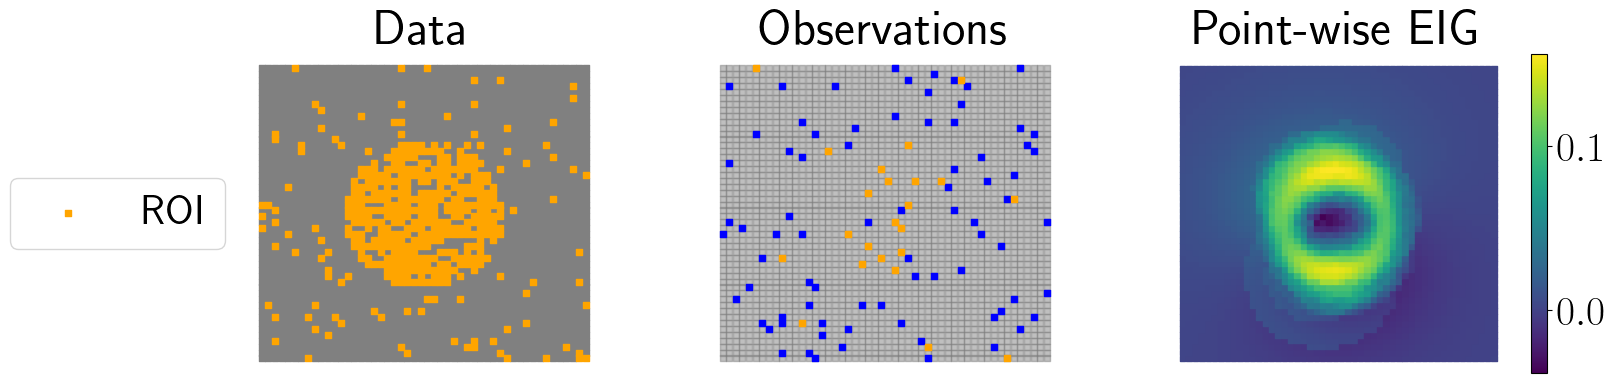

In [21]:
model = Model(prior_mean=prior_mean, prior_stddev=onp.sqrt(prior_variance))


n_experimental_iters = 1
limits = [-3, 3]
grid_size = 50
radius = 1.5
center = onp.array([0, 0])
x1s = onp.linspace(*limits, num=grid_size)
x2s = onp.linspace(*limits, num=grid_size)
X1, X2 = onp.meshgrid(x1s, x2s)
X = onp.vstack([X1.ravel(), X2.ravel()]).T
norms = onp.linalg.norm(X - center, axis=1)
Y = (norms < radius).astype(int)


# Randomly flip some labels
tumor_idx = onp.where(Y == 1)[0]
# flip_list = onp.random.binomial(n=1, p=0.8, size=len(tumor_idx))
Y[tumor_idx] = flip_list
flip_idx = onp.random.choice(onp.arange(len(Y)), size=int(0.05 * len(Y)), replace=False)
Y[flip_idx] = 1 - Y[flip_idx]


# idx_for_designs = onp.random.choice(onp.arange(len(X)), size=20, replace=False)
idx_for_designs = onp.arange(len(X))


observed_idx = onp.random.choice(onp.arange(len(X)), size=100, replace=False).tolist()
# observed_idx = onp.arange(len(X))
# observed_idx = []

for iternum in range(n_experimental_iters):

    variational_model = ApproximateModel(key=PRNGKey(iternum))

    if len(observed_idx) == 0:
        fitted_params = jnp.zeros(8) - 1
    else:
        fitted_params = fit_variational_model(
            X=X[onp.unique(onp.array(observed_idx))],
            Y=Y[onp.unique(onp.array(observed_idx))],
            model_object=model,
        )

    radius_mean = jnp.exp(fitted_params[0] + 0.5 * jnp.exp(fitted_params[4]) ** 2)
    print(radius_mean)
    print("Center: ", fitted_params[2:4])

    best_eig = -onp.inf

    # Get data for this fragment

    eigs = []
    for dd in tqdm(idx_for_designs):

        curr_eig = nmc(
            design=X[dd].reshape(1, -1),
            variational_params=fitted_params,
        )
        eigs.append(curr_eig)

        if curr_eig > best_eig:
            best_observed_idx = dd
            best_eig = curr_eig

    observed_idx.append(best_observed_idx)

    plt.close()
    # plt.figure(figsize=(17, 5))
    fig, axs = plt.subplots(
        1, 3, figsize=(17, 5), gridspec_kw={"width_ratios": [1, 1, 1.2]}
    )
    # plt.subplot(131)
    plt.sca(axs[0])
    plt.title("Data")
    for c in [0, 1]:
        curr_idx = onp.where(Y == c)[0]
        plt.scatter(
            X[curr_idx, 0], X[curr_idx, 1],
            label="ROI" if c == 1 else None,
            c="orange" if c == 1 else "gray",
            marker="s",
            s=15,
        )

    plt.legend(loc="center right", bbox_to_anchor=(0, 0.5))
    plt.axis("off")
    plt.tight_layout()

    # plt.subplot(132)
    plt.sca(axs[1])
    plt.title("Observations")
    plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5, s=15, marker="s")

    for c in [0, 1]:
        curr_idx = onp.where(Y[onp.array(observed_idx)] == c)[0]
        plt.scatter(
            X[onp.array(observed_idx)[curr_idx], 0],
            X[onp.array(observed_idx)[curr_idx], 1],
            # c=Y[onp.array(observed_idx)],
            c="orange" if c == 1 else "blue",
            marker="s",
            s=15,
        )
    # plt.scatter(X[best_observed_idx, 0], X[best_observed_idx, 1], c="red")
    plt.axis("off")
    plt.tight_layout()

    # plt.subplot(133)
    plt.sca(axs[2])
    plt.title("Point-wise EIG")
    plt.scatter(X[idx_for_designs, 0], X[idx_for_designs, 1], c=eigs, s=15, marker="s")
    # plt.xlim(limits)
    # plt.ylim(limits)
    plt.colorbar()
    plt.axis("off")

    # plt.subplot(133)
    # preds = model.predict(
    #     X=X, radius=radius_mean, slope=fitted_params[2], center=fitted_params[2:4]
    # )
    # plt.scatter(X[:, 0], X[:, 1], c=preds)

    # plt.savefig("./out/border_finding_data_and_eig.png")
    # plt.show()
    # plt.draw()
    # plt.pause(1.)
    # import ipdb; ipdb.set_trace()
    break


##########################################################################################
##########################################################################################
##########################################################################################
##########################################################################################


# Discretize design space
n_intercept_discretizations = 25
slopes = onp.zeros(n_intercept_discretizations)
intercepts = onp.linspace(limits[0], limits[1], n_intercept_discretizations)
candidate_designs = onp.vstack([intercepts, slopes]).T
n_candidate_designs = len(candidate_designs)

Xs_for_designs = []
for ii, dd in enumerate(candidate_designs):
    # curr_idx = get_points_near_line(slope=dd[1], X=X, intercept=dd[0])
    # curr_X = X[curr_idx]
    # Xs_for_designs.append(curr_X)

    curr_X1 = onp.linspace(limits[0], limits[1], grid_size)
    curr_X2 = onp.repeat(dd[0], grid_size)
    curr_X = onp.vstack([curr_X1, curr_X2]).T
    Xs_for_designs.append(curr_X)

# observed_idx = onp.random.choice(onp.arange(len(X)), size=20, replace=False).tolist()
# observed_idx = onp.arange(len(X))
observed_idx = []

best_designs = []
X_fragment_idx = [onp.arange(len(X))]

for iternum in range(n_experimental_iters):

    assert len(best_designs) == iternum
    assert len(X_fragment_idx) == iternum + 1

    variational_model = ApproximateModel(key=PRNGKey(iternum))

    if len(observed_idx) == 0:
        fitted_params = jnp.zeros(8) - 1
    else:
        fitted_params = fit_variational_model(
            X=X[onp.unique(onp.array(observed_idx))],
            Y=Y[onp.unique(onp.array(observed_idx))],
            model_object=model,
            verbose=False,
        )

    radius_mean = jnp.exp(fitted_params[0] + 0.5 * jnp.exp(fitted_params[4]) ** 2)
    print(radius_mean)
    print("Center: ", fitted_params[2:4])

#     best_eig = -onp.inf
#     best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

#     eigs = []
#     # for dd in tqdm(Xs_for_designs):
#     for dd in tqdm(range(len(candidate_designs))):

#         # Get points that would be observed by this slice
#         curr_design = candidate_designs[dd]

#         # curr_observed_idx = get_points_near_line(
#         #     X=X, slope=curr_design[1], intercept=curr_design[0]
#         # )
#         # if len(curr_observed_idx) == 0:
#         #     continue

#         # design_mask = onp.zeros(len(X))
#         # design_mask[curr_observed_idx] = 1

#         # curr_eig = nmc(
#         #     # design=curr_X[curr_observed_idx],
#         #     design=jnp.array(design_mask),
#         #     variational_params=fitted_params,
#         # )
#         curr_eig = nmc(
#             design=Xs_for_designs[dd],
#             variational_params=fitted_params,
#         )
#         eigs.append(curr_eig)

#         if curr_eig > best_eig:
#             best_design_idx = dd
#             best_eig = curr_eig

#     plt.sca(axs[3])
#     plt.title("Slice-wise EIG")
#     # plt.scatter(X[:, 0], X[:, 1])
#     for dd in range(len(candidate_designs)):
#         curr_X = Xs_for_designs[dd]
#         plt.scatter(
#             curr_X[:, 0],
#             curr_X[:, 1],
#             c=onp.repeat(eigs[dd], len(curr_X)),
#             vmin=onp.min(eigs),
#             vmax=onp.max(eigs),
#             s=20,
#             marker="s",
#         )
#     # plt.xlim(limits)
#     # plt.ylim(limits)
#     plt.axis("off")
#     plt.colorbar()
#     plt.tight_layout()
    plt.savefig("./out/border_finding_data_and_eig.png")
    plt.show()
